# **Residual Networks (ResNet)**

At the heart of their proposed residual network (ResNet) is the idea that every additional layer should more easily contain the identity function as one of its elements. These considerations are rather profound but they led to a surprisingly simple solution, a residual block. With it, ResNet won the ImageNet Large Scale Visual Recognition Challenge in 2015. The design had a profound influence on how to build deep neural networks.

In [1]:
# Install d2l Module
!pip install d2l

In [2]:
# Residual Blocks
import tensorflow as tf
from d2l import tensorflow as d2l


class Residual(tf.keras.Model): 
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, padding='same', kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, kernel_size=3, padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(
                num_channels, kernel_size=1, strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)

In [3]:
# Define shape
blk = Residual(3)
X = tf.random.uniform((4, 6, 6, 3))
Y = blk(X)
Y.shape

TensorShape([4, 6, 6, 3])

In [4]:
# Output height and width
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

TensorShape([4, 3, 3, 6])

In [5]:
# ResNet model
b1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')])

In [6]:
# Implementation
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

In [7]:
# Residual blocks for each modules
b2 = ResnetBlock(64, 2, first_block=True)
b3 = ResnetBlock(128, 2)
b4 = ResnetBlock(256, 2)
b5 = ResnetBlock(512, 2)

In [8]:
# Adding global average pooling layer
def net():
    return tf.keras.Sequential([
        # The following layers are the same as b1 that we created earlier
        tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
        # The following layers are the same as b2, b3, b4, and b5 that we
        # created earlier
        ResnetBlock(64, 2, first_block=True),
        ResnetBlock(128, 2),
        ResnetBlock(256, 2),
        ResnetBlock(512, 2),
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(units=10)])

In [9]:
# Observing how the inputs shape changes across different modules
X = tf.random.uniform(shape=(1, 96, 96, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Conv2D output shape:	 (1, 48, 48, 64)
BatchNormalization output shape:	 (1, 48, 48, 64)
Activation output shape:	 (1, 48, 48, 64)
MaxPooling2D output shape:	 (1, 24, 24, 64)
ResnetBlock output shape:	 (1, 24, 24, 64)
ResnetBlock output shape:	 (1, 12, 12, 128)
ResnetBlock output shape:	 (1, 6, 6, 256)
ResnetBlock output shape:	 (1, 3, 3, 512)
GlobalAveragePooling2D output shape:	 (1, 512)
Dense output shape:	 (1, 10)


KeyboardInterrupt: ignored

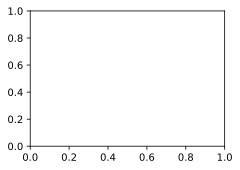

In [11]:
# Training
lr, num_epochs, batch_size = 0.05, 10, 10
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=24)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())